In [3]:
import random
import pandas as pd
import numpy as np
import math

df = pd.read_csv('balanced_data.csv')
print(df.head())

   LOC_BLANK  BRANCH_COUNT  LOC_CODE_AND_COMMENT  LOC_COMMENTS  \
0        447           826                    12           157   
1         37            29                     8            42   
2         11           405                     0            17   
3        106           240                     7           344   
4        101           464                    11            75   

   CYCLOMATIC_COMPLEXITY  DESIGN_COMPLEXITY  ESSENTIAL_COMPLEXITY  \
0                    470                385                   113   
1                     19                 19                     6   
2                    404                  2                     1   
3                    127                105                    33   
4                    263                256                   140   

   LOC_EXECUTABLE  HALSTEAD_CONTENT  HALSTEAD_DIFFICULTY  ...  \
0            2824            210.28               384.45  ...   
1             133            108.14                46.32  

In [4]:
features = ['LOC_BLANK','BRANCH_COUNT','LOC_CODE_AND_COMMENT','LOC_COMMENTS','CYCLOMATIC_COMPLEXITY','DESIGN_COMPLEXITY',
            'ESSENTIAL_COMPLEXITY','LOC_EXECUTABLE','HALSTEAD_CONTENT','HALSTEAD_DIFFICULTY','HALSTEAD_EFFORT','HALSTEAD_ERROR_EST',
            'HALSTEAD_LENGTH','HALSTEAD_LEVEL','HALSTEAD_PROG_TIME','HALSTEAD_VOLUME','NUM_OPERANDS','NUM_OPERATORS','NUM_UNIQUE_OPERANDS',
            'NUM_UNIQUE_OPERATORS','LOC_TOTAL']
nb_train = int(np.floor(0.9 * len(df)))
df = df.sample(frac=1, random_state=217)
X_train = df[features][:nb_train]
y_train = df['label'][:nb_train].values
X_test = df[features][nb_train:]
y_test = df['label'][nb_train:].values

In [5]:
def entropy(p):
    if isinstance(p, (int, float)):
        if p == 0 or p == 1:
            return 0
        else:
            return -p * (p - (2 * p * p / 2) + (2 * p * p * p / 3))
    elif isinstance(p, (list, tuple)):
        entropy_value = 0
        for prob in p:
            entropy_value -= prob * (prob - (2 * prob * prob / 2) + (2 * prob * prob * prob / 3))
        return entropy_value
    else:
        raise ValueError("Invalid input type for entropy function")


        
def information_gain(left_child, right_child):
    parent = left_child + right_child
    p_parent = parent.count(1) / len(parent) if len(parent) > 0 else 0
    p_left = left_child.count(1) / len(left_child) if len(left_child) > 0 else 0
    p_right = right_child.count(1) / len(right_child) if len(right_child) > 0 else 0
    IG_p = entropy(p_parent)
    IG_l = entropy(p_left)
    IG_r = entropy(p_right)
    return IG_p - len(left_child) / len(parent) * IG_l - len(right_child) / len(parent) * IG_r

In [6]:
def draw_bootstrap(X_train, y_train):
    bootstrap_indices = list(np.random.choice(range(len(X_train)), len(X_train), replace = True))
    oob_indices = [i for i in range(len(X_train)) if i not in bootstrap_indices]
    X_bootstrap = X_train.iloc[bootstrap_indices].values
    y_bootstrap = y_train[bootstrap_indices]
    X_oob = X_train.iloc[oob_indices].values
    y_oob = y_train[oob_indices]
    return X_bootstrap, y_bootstrap, X_oob, y_oob

def oob_score(tree, X_test, y_test):
    mis_label = 0
    for i in range(len(X_test)):
        pred = predict_tree(tree, X_test[i])
        if pred != y_test[i]:
            mis_label += 1
    return mis_label / len(X_test)

In [7]:
def find_split_point(X_bootstrap, y_bootstrap, max_features):
    feature_ls = list()
    num_features = len(X_bootstrap[0])

    while len(feature_ls) <= max_features:
        feature_idx = random.sample(range(num_features), 1)
        if feature_idx not in feature_ls:
            feature_ls.extend(feature_idx)

    best_info_gain = -999
    node = None
    for feature_idx in feature_ls:
        for split_point in X_bootstrap[:,feature_idx]:
            left_child = {'X_bootstrap': [], 'y_bootstrap': []}
            right_child = {'X_bootstrap': [], 'y_bootstrap': []}

        # split children for continuous variables
        if type(split_point) in [int, float]:
            for i, value in enumerate(X_bootstrap[:,feature_idx]):
                if value <= split_point:
                    left_child['X_bootstrap'].append(X_bootstrap[i])
                    left_child['y_bootstrap'].append(y_bootstrap[i])
                else:
                    right_child['X_bootstrap'].append(X_bootstrap[i])
                    right_child['y_bootstrap'].append(y_bootstrap[i])
        # split children for categoric variables
        else:
            for i, value in enumerate(X_bootstrap[:,feature_idx]):
                if value == split_point:
                    left_child['X_bootstrap'].append(X_bootstrap[i])
                    left_child['y_bootstrap'].append(y_bootstrap[i])
                else:
                    right_child['X_bootstrap'].append(X_bootstrap[i])
                    right_child['y_bootstrap'].append(y_bootstrap[i])

        split_info_gain = information_gain(left_child['y_bootstrap'], right_child['y_bootstrap'])
        if split_info_gain > best_info_gain:
            best_info_gain = split_info_gain
            left_child['X_bootstrap'] = np.array(left_child['X_bootstrap'])
            right_child['X_bootstrap'] = np.array(right_child['X_bootstrap'])
            node = {'information_gain': split_info_gain,
                    'left_child': left_child,
                    'right_child': right_child,
                    'split_point': split_point,
                    'feature_idx': feature_idx}


    return node

In [8]:
def terminal_node(node):
    y_bootstrap = node['y_bootstrap']
    pred = max(y_bootstrap, key = y_bootstrap.count)
    return pred


def split_node(node, max_features, min_samples_split, max_depth, depth):
    left_child = node['left_child']
    right_child = node['right_child']

    del(node['left_child'])
    del(node['right_child'])

    if len(left_child['y_bootstrap']) == 0 or len(right_child['y_bootstrap']) == 0:
        empty_child = {'y_bootstrap': left_child['y_bootstrap'] + right_child['y_bootstrap']}
        node['left_split'] = terminal_node(empty_child)
        node['right_split'] = terminal_node(empty_child)
        return

    if depth >= max_depth:
        node['left_split'] = terminal_node(left_child)
        node['right_split'] = terminal_node(right_child)
        return node

    if len(left_child['X_bootstrap']) <= min_samples_split:
        node['left_split'] = node['right_split'] = terminal_node(left_child)
    else:
        node['left_split'] = find_split_point(left_child['X_bootstrap'], left_child['y_bootstrap'], max_features)
        split_node(node['left_split'], max_depth, min_samples_split, max_depth, depth + 1)
    if len(right_child['X_bootstrap']) <= min_samples_split:
        node['right_split'] = node['left_split'] = terminal_node(right_child)
    else:
        node['right_split'] = find_split_point(right_child['X_bootstrap'], right_child['y_bootstrap'], max_features)
        split_node(node['right_split'], max_features, min_samples_split, max_depth, depth + 1)

In [9]:
def build_tree(X_bootstrap, y_bootstrap, max_depth, min_samples_split, max_features):
    root_node = find_split_point(X_bootstrap, y_bootstrap, max_features)
    split_node(root_node, max_features, min_samples_split, max_depth, 1)
    return root_node

def random_forest(X_train, y_train, n_estimators, max_features, max_depth, min_samples_split):
    tree_ls = list()
    oob_ls = list()
    for i in range(n_estimators):
        X_bootstrap, y_bootstrap, X_oob, y_oob = draw_bootstrap(X_train, y_train)
        tree = build_tree(X_bootstrap, y_bootstrap, max_features, max_depth, min_samples_split)
        tree_ls.append(tree)
        oob_error = oob_score(tree, X_oob, y_oob)
        oob_ls.append(oob_error)
    print("OOB estimate: {:.2f}".format(np.mean(oob_ls)))
    return tree_ls

In [10]:
def predict_tree(tree, X_test):
    feature_idx = tree['feature_idx']

    if X_test[feature_idx] <= tree['split_point']:
        if type(tree['left_split']) == dict:
            return predict_tree(tree['left_split'], X_test)
        else:
            value = tree['left_split']
            return value
    else:
        if type(tree['right_split']) == dict:
            return predict_tree(tree['right_split'], X_test)
        else:
            return tree['right_split']

In [11]:
def predict_rf(tree_ls, X_test):
    pred_ls = list()
    for i in range(len(X_test)):
        ensemble_preds = [predict_tree(tree, X_test.values[i]) for tree in tree_ls]
        final_pred = max(ensemble_preds, key = ensemble_preds.count)
        pred_ls.append(final_pred)
    return np.array(pred_ls)

In [12]:
n_estimators = 100
max_features = 10
max_depth = 10
min_samples_split = 3

model = random_forest(X_train, y_train, n_estimators=100, max_features=10, max_depth=10, min_samples_split=3)

OOB estimate: 0.47


In [13]:
preds = predict_rf(model, X_test)
acc = sum(preds == y_test) / len(y_test)
print("Testing accuracy: {}".format(np.round(acc,3)))

Testing accuracy: 0.53


In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print("Entropy Value: ",entropy)
# Calculate accuracy
accuracy = accuracy_score(y_test, preds)
print("Testing accuracy:", accuracy)

# Construct confusion matrix
conf_matrix = confusion_matrix(y_test, preds)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision
precision = precision_score(y_test, preds, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, preds, average='weighted')
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_test, preds, average='weighted')
print("F1 Score:", f1)

Entropy Value:  <function entropy at 0x00000208A58AFD80>
Testing accuracy: 0.529746835443038
Confusion Matrix:
[[ 12 741]
 [  2 825]]
Precision: 0.6842459797828632
Recall: 0.529746835443038
F1 Score: 0.3758149289654996


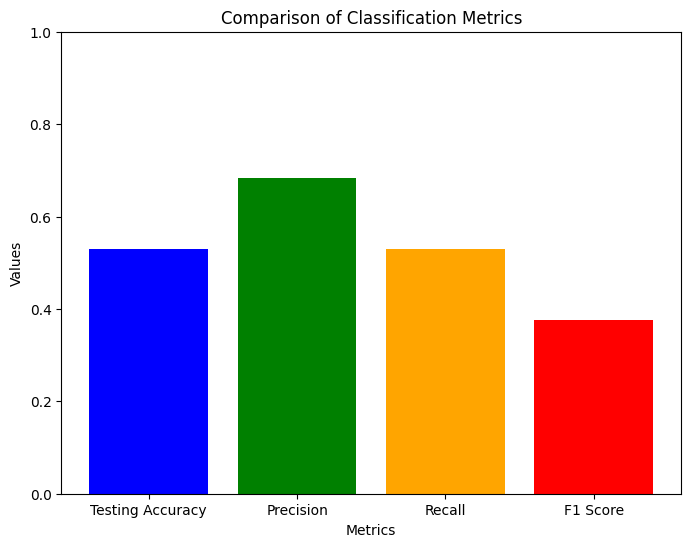

In [15]:
import matplotlib.pyplot as plt

# Define the metrics and their values
metrics = ['Testing Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Classification Metrics')
plt.ylim(0, 1)  # Limit y-axis to [0, 1]
plt.show()

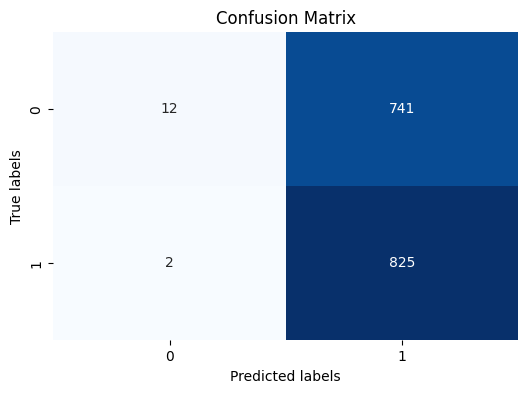

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Calculate confusion matrix
cm = confusion_matrix(y_test, preds)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()